# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [172]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [173]:
# using SQLite Table to read data.
con = sqlite3.connect('D:/Applied Ai/Datasets/Amazon food reviews/database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3  """, con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [174]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [175]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B005ZBZLT4,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ESG,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B005ZBZLT4,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ESG,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBEV0,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [176]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B001ATMQK2,"undertheshrine ""undertheshrine""",1296691200,5,I bought this 6 pack because for the price tha...,5


In [177]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [178]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [179]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [180]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [181]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [182]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [183]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [184]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


1    307061
0     57110
Name: Score, dtype: int64

In [185]:
final=final.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [186]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
I can't believe that you can actually buy Coke products on Amazon!<br /><br />If I was going to order any soft drink online, it would be Diet Coke with Lime.  The lime improves the taste of Diet Coke signifigantally and makes the aftertaste (from the artificial sweetener) much less noticeable.  Coke has quite intelligently taken  one of the mixes that many beverage-drinkers have been enjoying for years and made it available as a consistently-mixed, no knife (to peel the lime) needed version!
This is the best hot chocolate.  I first tried this in California and hoped that one day I could find it at a local market.  I 

In [187]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college


In [188]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
I can't believe that you can actually buy Coke products on Amazon!If I was going to order any soft drink online, it would be Diet Coke with Lime.  The lime improves the taste of Diet Coke signifigantally and makes the aftertaste (from the artificial sweetener) much less noticeable.  Coke has quite intelligently taken  one of the mixes that many beverage-drinkers have been enjoying for years and made it available as a consistently-mixed, no knife (to peel the lime) needed version!
This is the best hot chocolate.  I first tried this in California and hoped that one day I could find it at a local market.  I was excited 

In [189]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [190]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

This is the best hot chocolate.  I first tried this in California and hoped that one day I could find it at a local market.  I was excited to find it at Amazon and now I get it shipped to me for gifts and for my husband and myself.


In [191]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college


In [192]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

This is the best hot chocolate I first tried this in California and hoped that one day I could find it at a local market I was excited to find it at Amazon and now I get it shipped to me for gifts and for my husband and myself 


In [193]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [194]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())


  9%|▉         | 33028/364171 [00:15<02:29, 2222.19it/s]


 19%|█▉        | 70153/364171 [00:30<01:51, 2643.01it/s]


 30%|██▉       | 108689/364171 [00:45<01:46, 2407.40it/s]


 40%|████      | 145790/364171 [01:00<01:29, 2435.93it/s]


 50%|█████     | 183645/364171 [01:15<01:11, 2510.77it/s]


 61%|██████    | 221882/364171 [01:30<00:53, 2669.13it/s]


 71%|███████   | 259429/364171 [01:45<00:41, 2535.61it/s]


 81%|████████▏ | 296401/364171 [02:00<00:27, 2467.37it/s]


 92%|█████████▏| 333508/364171 [02:14<00:12, 2492.83it/s]


100%|██████████| 364171/364171 [02:26<00:00, 2489.85it/s]


In [196]:
preprocessed_reviews[1500]

'best hot chocolate first tried california hoped one day could find local market excited find amazon get shipped gifts husband'

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [0]:
## Similartly you can do preprocessing for review summary also.

# [4] Featurization

## [4.3] TF-IDF

In [197]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,1), min_df=10)
tf_idf_vect.fit(preprocessed_reviews)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['aa', 'aaa', 'aaaaa', 'aaah', 'aafco', 'ab', 'aback', 'abandon', 'abandoned', 'abbey']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (364171, 22703)
the number of unique words including both unigrams and bigrams  22703


# [5] Assignment 11: Truncated SVD

<ol>
    <li><strong>Apply Truncated-SVD on only this feature set:</strong>
        <ul>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
    <br>
    <li><strong>Procedure:</strong>
        <ul>
    <li>Take top 2000 or 3000 features from tf-idf vectorizers using idf_ score.</li>
    <li>You need to calculate the co-occurrence matrix with the selected features (Note: X.X^T
doesn’t give the co-occurrence matrix, it returns the covariance matrix, check these
        bolgs <a href='https://medium.com/data-science-group-iitr/word-embedding-2d05d270b285'>blog-1,</a> <a href='https://www.analyticsvidhya.com/blog/2017/06/word-embeddings-count-word2veec/'>blog-2 </a>for more information)</li>
            <li>You should choose the n_components in truncated svd, with maximum explained
variance. Please search on how to choose that and implement them. (hint: plot of
cumulative explained variance ratio)</li>
            <li>After you are done with the truncated svd, you can apply K-Means clustering and choose
the best number of clusters based on elbow method.</li>
            <li> Print out wordclouds for each cluster, similar to that in previous assignment. </li>
            <li>You need to write a function that takes a word and returns the most similar words using
cosine similarity between the vectors(vector: a row in the matrix after truncatedSVD)</li>
        </ul>
    </li>
    <br>
    
</ol>

## Truncated-SVD

### [5.1] Taking top features from TFIDF,<font color='red'> SET 2</font>

In [198]:
# Please write all the code with proper documentation
idf_sc=tf_idf_vect.idf_
feature_names=tf_idf_vect.get_feature_names()

In [199]:
# taking top 3000 features
idf_sc_3000=idf_sc.argsort()[::-1][:3000]
topfeatures_3000=[]
for i in idf_sc_3000:
    topfeatures_3000.append(feature_names[i])
    
topfeatures_3000

  

                            
    


    

['crinkled',
 'prosper',
 'psst',
 'prozac',
 'cw',
 'cyanocobalamin',
 'alwadi',
 'cycled',
 'dabbed',
 'proprietor',
 'viewers',
 'daikon',
 'daisies',
 'alto',
 'altitudes',
 'prompts',
 'alterra',
 'dante',
 'psychedelic',
 'pubs',
 'quercetin',
 'qualification',
 'queasiness',
 'vibrance',
 'vibrantly',
 'vic',
 'quantify',
 'vices',
 'qualifying',
 'cu',
 'cus',
 'purge',
 'cud',
 'cultivate',
 'amanda',
 'punjab',
 'pulps',
 'currency',
 'profess',
 'alternates',
 'dashing',
 'portray',
 'practiced',
 'defying',
 'degrading',
 'vitamuffins',
 'delite',
 'possessive',
 'vocabulary',
 'voicemail',
 'dawg',
 'pondered',
 'pomodoro',
 'polyphenol',
 'polluting',
 'pointsplus',
 'poas',
 'desiccated',
 'definitions',
 'defining',
 'prances',
 'preceding',
 'privately',
 'prisrob',
 'dealings',
 'dearest',
 'pricer',
 'decaffeinating',
 'decaying',
 'presuming',
 'presentations',
 'deeeelicious',
 'defecating',
 'preferida',
 'deffinatly',
 'precut',
 'preconceptions',
 'crossfit',
 '

### [5.2] Calulation of Co-occurrence matrix

In [200]:
# Please write all the code with proper documentation
cocc_mat=np.zeros((3000,3000))
context_window=2

In [201]:
for sentance in tqdm(preprocessed_reviews):
    words_in_sent=sentance.split()
    
    for idx,word in enumerate(words_in_sent):
        if word in  topfeatures_3000:
            
            for i in range(max(0,idx-context_window),min(idx+context_window,len(words_in_sent)-1)+1):
                
                if words_in_sent[i] in topfeatures_3000 and words_in_sent[i]!=word:
                    cocc_mat[ topfeatures_3000.index(words_in_sent[i]), topfeatures_3000.index(word)]+=1


  0%|          | 1685/364171 [00:19<1:41:30, 59.52it/s]


  1%|          | 3601/364171 [00:39<1:48:58, 55.15it/s]


  1%|▏         | 5440/364171 [00:58<1:04:18, 92.96it/s]


  2%|▏         | 8277/364171 [01:16<39:44, 149.27it/s]


  3%|▎         | 10829/364171 [01:35<39:43, 148.22it/s]


  4%|▎         | 13038/364171 [01:54<49:57, 117.13it/s]


  5%|▌         | 18967/364171 [02:10<10:03, 571.84it/s]


  8%|▊         | 28192/364171 [02:26<12:06, 462.77it/s]


 10%|▉         | 35120/364171 [02:43<16:26, 333.58it/s]


 11%|█▏        | 40980/364171 [03:00<11:32, 466.94it/s]


 13%|█▎        | 49088/364171 [03:16<11:00, 476.92it/s]


 16%|█▌        | 57737/364171 [03:32<09:17, 549.17it/s]


 18%|█▊        | 65592/364171 [03:48<08:25, 590.57it/s]


 20%|██        | 73903/364171 [04:04<09:31, 507.93it/s]


 23%|██▎       | 82127/364171 [04:20<08:06, 580.25it/s]


 25%|██▍       | 90494/364171 [04:36<09:06, 500.63it/s]


 27%|██▋       | 98770/364171 [04:51<10:06, 437.90it/s]


 29%|██▉       | 105841/364171 [05:08<08:32, 504.12it/s]


 31%|███       | 112093/364171 [05:24<10:10, 413.01it/s]


 32%|███▏      | 118104/364171 [05:40<10:41, 383.29it/s]


 34%|███▎      | 122776/364171 [05:58<18:20, 219.42it/s]


 35%|███▌      | 129050/364171 [06:14<08:48, 444.85it/s]


 38%|███▊      | 136774/364171 [06:30<12:40, 298.88it/s]


 39%|███▉      | 143263/364171 [06:46<12:21, 297.89it/s]


 41%|████      | 149669/364171 [07:02<14:16, 250.54it/s]


 43%|████▎     | 157379/364171 [07:18<06:30, 529.08it/s]


 46%|████▌     | 165986/364171 [07:33<06:52, 480.02it/s]


 48%|████▊     | 174598/364171 [07:49<06:44, 468.83it/s]


 50%|█████     | 183144/364171 [08:04<06:31, 462.29it/s]


 53%|█████▎    | 191330/364171 [08:20<04:59, 576.90it/s]


 55%|█████▍    | 200159/364171 [08:35<07:12, 378.99it/s]


 57%|█████▋    | 207148/364171 [08:51<06:31, 400.85it/s]


 59%|█████▉    | 214358/364171 [09:06<05:46, 432.97it/s]


 61%|██████    | 221431/364171 [09:22<04:16, 555.82it/s]


 63%|██████▎   | 229251/364171 [09:38<04:57, 453.25it/s]


 65%|██████▌   | 237447/364171 [09:53<04:41, 450.56it/s]


 67%|██████▋   | 245255/364171 [10:08<04:04, 486.85it/s]


 69%|██████▉   | 252396/364171 [10:24<03:44, 497.68it/s]


 71%|███████▏  | 259667/364171 [10:40<03:53, 448.42it/s]


 73%|███████▎  | 266700/364171 [10:55<04:30, 360.40it/s]


 75%|███████▌  | 273591/364171 [11:11<03:34, 422.96it/s]


 77%|███████▋  | 281129/364171 [11:26<03:04, 450.27it/s]


 79%|███████▉  | 288546/364171 [11:42<02:23, 528.56it/s]


 81%|████████▏ | 296003/364171 [11:58<02:30, 453.95it/s]


 83%|████████▎ | 303136/364171 [12:13<02:07, 479.39it/s]


 85%|████████▌ | 310552/364171 [12:29<01:56, 461.94it/s]


 87%|████████▋ | 318613/364171 [12:44<01:27, 523.34it/s]


 89%|████████▉ | 325717/364171 [13:00<01:30, 424.09it/s]


 92%|█████████▏| 333282/364171 [13:15<01:09, 443.72it/s]


 94%|█████████▎| 341254/364171 [13:31<00:43, 528.23it/s]


 96%|█████████▌| 349180/364171 [13:46<00:31, 468.48it/s]


 98%|█████████▊| 356866/364171 [14:01<00:14, 508.63it/s]


100%|██████████| 364171/364171 [14:14<00:00, 425.95it/s]


### TOY-EXAMPLE

In [204]:
corpus=["abc def ijk pqr","pqr klm opq","lmn pqr xyz abc def pqr abc"]
topwords=["abc", "pqr", "def"]
window_size=2
coccurence_mat=np.zeros((3,3))
for sentance in tqdm(corpus):
    words_in_sent=sentance.split()
    
    for idx,word in enumerate(words_in_sent):
        if word in  topwords:
            
            for i in range(max(0,idx-window_size),min(idx+window_size,len(words_in_sent)-1)+1):
                
                   
                if words_in_sent[i] in topwords and words_in_sent[i]!=word:
                    coccurence_mat[ topwords.index(words_in_sent[i]),topwords.index(word)]+=1
                    


coccurence_mat
res=pd.DataFrame(data=coccurence_mat,columns=topwords)
new_col=topwords
res.insert(loc=0, column="topwords", value=new_col)

res



100%|██████████| 3/3 [00:00<?, ?it/s]


,topwords,abc,pqr,def
0,abc,0.0,3.0,3.0
1,pqr,3.0,0.0,2.0
2,def,3.0,2.0,0.0


### [5.3] Finding optimal value for number of components (n) to be retained.

n_components= 10 Explained variance= 0.4054325902104588
n_components= 20 Explained variance= 0.6124747023524499
n_components= 50 Explained variance= 0.7769746905907667
n_components= 100 Explained variance= 0.8448972971097654
n_components= 200 Explained variance= 0.903020673614726
n_components= 300 Explained variance= 0.9320523382672797
n_components= 400 Explained variance= 0.9609033532787744
n_components= 500 Explained variance= 0.9897402190097728
n_components= 600 Explained variance= 1.0000000000000318
n_components= 700 Explained variance= 1.0000000000000409
n_components= 800 Explained variance= 1.0000000000000373
n_components= 900 Explained variance= 1.0000000000000433
n_components= 1000 Explained variance= 1.0000000000000229
n_components= 1200 Explained variance= 1.0000000000000338
n_components= 2000 Explained variance= 1.000000000000032
n_components= 2500 Explained variance= 1.0000000000000346


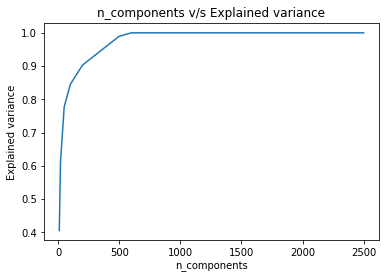

In [203]:
# Please write all the code with proper documentation
from sklearn.decomposition import TruncatedSVD
n_components=[10,20,50,100,200,300,400,500,600,700,800,900,1000,1200,2000,2500]
exp_var=[]
for n in n_components:
    tsvd=TruncatedSVD(n_components=n)
    tsvd.fit(cocc_mat)
    expvar=tsvd.explained_variance_ratio_.sum()
    exp_var.append(expvar)
    print('n_components=',n,'Explained variance=',expvar)
plt.plot(n_components, exp_var)
plt.xlabel('n_components')
plt.ylabel("Explained variance")
plt.title("n_components v/s Explained variance")
plt.show()
    
  



### From the curve we know that the maximum variance explained is within 500 and 600 so we will experiment with the components between 500 and 600 to  get the optimal component

In [205]:
n_components=np.arange(500,600,10)
exp_var=[]
for n in n_components:
    tsvd=TruncatedSVD(n_components=n)
    tsvd.fit(cocc_mat)
    expvar=tsvd.explained_variance_ratio_.sum()
    exp_var.append(expvar)
    print('n_components=',n,'Explained variance=',expvar)

n_components= 500 Explained variance= 0.9897427876605742
n_components= 510 Explained variance= 0.9926193485776906
n_components= 520 Explained variance= 0.9954909920144089
n_components= 530 Explained variance= 0.9975956018602498
n_components= 540 Explained variance= 0.9988183255950667
n_components= 550 Explained variance= 0.9997848023501413
n_components= 560 Explained variance= 1.0000000000000309
n_components= 570 Explained variance= 1.0000000000000344
n_components= 580 Explained variance= 1.0000000000000344
n_components= 590 Explained variance= 1.0000000000000442


### So we find number of components =550 will give us the maximum variance of 99.9 %

In [206]:
n_comp=550

In [207]:
tsvd=TruncatedSVD(n_components=n_comp)
X=tsvd.fit_transform(cocc_mat)


### [5.4] Applying k-means clustering

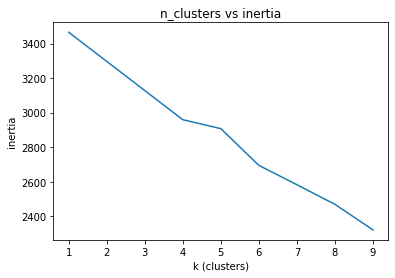

In [208]:
# Please write all the code with proper documentation
from sklearn.cluster import KMeans
#applying K-means clustering and finding best k using elbow method
#first put the optimal n_components into truncated svd to find our train data

K=np.arange(1,10,1)
inertia=[]

for k in K:
    model=KMeans(n_clusters=k)
    model.fit(X)
    inertia.append(model.inertia_)
plt.plot(K,inertia)
plt.xlabel('k (clusters)')
plt.ylabel('inertia')
plt.title('n_clusters vs inertia')
plt.show()


### So from the curve number of clusters can be taken as 4

In [209]:
n_clusters=4

In [210]:
model=KMeans(n_clusters=n_clusters).fit(X)

In [211]:
results = pd.DataFrame()
results['text'] = topfeatures_3000
results['cluster'] = model.labels_
results



,text,cluster
0,crinkled,0
1,prosper,0
2,psst,0
3,prozac,0
4,cw,0
...,...,...
2995,overcharge,0
2996,doone,0
2997,buffets,0
2998,reade,0


### [5.5] Wordclouds of clusters obtained in the above section

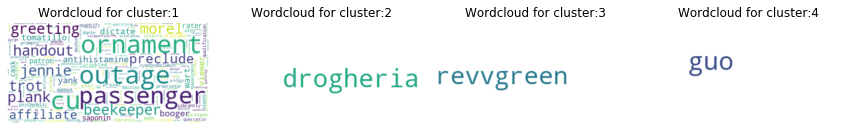

In [212]:
# Please write all the code with proper documentation
from wordcloud import WordCloud
fig = plt.figure(figsize=(12,10))
for k in range(n_clusters):

        feat_cloud = " ".join(word for word in results[results['cluster']==k]['text'])
        wordcloud_pos = WordCloud(max_font_size=50, max_words=200, background_color="white").generate(feat_cloud)

        # Display the generated image:
        temp=k+1
        ax = fig.add_subplot(4,4,temp)

        #plt.subplot(temp)
        ax.imshow(wordcloud_pos, interpolation='bilinear')
        ax.axis("off")
        title='Wordcloud for cluster:'+str(k+1)
        ax.set_title(title)
plt.tight_layout()  
plt.show()
    

### [5.6] Function that returns most similar words for a given word.

In [213]:
# Please write all the code with proper documentation
from sklearn.metrics.pairwise import cosine_similarity
def similar_words(word,n):
    top_words=[]
    co_sim=cosine_similarity(cocc_mat)
    val=co_sim[topfeatures_3000.index(word)]
    #print(len(val))
    idx=np.argsort(val)
    for i in range(n):
        top_words.append(topfeatures_3000[idx[i]])
    return top_words

In [215]:
print(similar_words('recycleable',10))



['crinkled', 'thicknesses', 'wrists', 'judicious', 'dictates', 'persuade', 'pienaroma', 'perspirant', 'wrigleys', 'dictate']


# [6] Conclusions


1)We took top 3000 features based on the idf_ score
2)now using SVD we took 550 components ,which explained 99.9% of the variance
3)By k means Clustering we took 4 clusters 
4)We plotted wordcloud for each clusters and found in some clusters there are few words and at the end we used a function which return most similar words using cosine similarity of co-occurence matrix.
